# This note is meant to provide a detailed and interactive treatment of mitigating the dilution risk associated with holding OVL. 



In [4]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
import pandas as pd
import numpy as np

In [5]:
@dataclass
class FundingAnalyzer:
    long: float     # OI long on hypothetical Overlay market
    short: float    # OI short on hypothetical Overlay market
    k: float = .02  # funding rate on hypothetical Overlay market

    def OI_tot(self):
        return self.long + self.short

    def OI_imb(self): #equation 13
        return self.long - self.short

    def OI_imb_delta(self, tau): #equation 14
        return self.OI_imb()*np.exp(-2*self.k*tau)

    def OI_tot_delta(self, tau): #equation 24
        return self.OI_tot()*np.sqrt(
            1 - (
                (self.OI_imb()/self.OI_tot())**2 \
                 * (1 - np.exp(-4*self.k*tau))
                )
            )

    def OI_br(self, tau): #equation 25
        return self.OI_tot() - self.OI_tot_delta(tau)

    def OI_l_delta(self, tau): #equation 26
        return .5*(self.OI_tot_delta(tau) + self.OI_imb_delta(tau))

    def OI_s_delta(self, tau): #equation 27
        return .5*(self.OI_tot_delta(tau) - self.OI_imb_delta(tau))

    def funding_rate(self): #equations 29-31
        return 2*self.k*np.abs(self.OI_imb())/self.OI_tot()

    def funding_earned(self, tau):
        if self.OI_imb() > 0: #imbalance is on the long side; longs pay shorts
            return  self.OI_s_delta(tau) - self.short
        return self.OI_l_delta(tau) - self.long

    def show_imb(self, timelen, step=1):
        R = np.arange(0, timelen + step, step)
        s = self.OI_s_delta(R)
        l = self.OI_l_delta(R)
        b = self.OI_br(R)
        p = self.funding_earned(R)
        t = s + l + b

        plt.plot(s, c='r', marker='o', label='short')
        plt.plot(l, c='g', marker='o', label='long')
        plt.plot(b, c='k', marker='o', label='burned')
        plt.plot(p, c='b', marker='o', label='profit')
        #plt.plot(t, c='magenta', marker='o', label='total')

        plt.xlabel(f'time in days')
        plt.ylabel(f'% of per-side cap')
        #plt.hlines(10, xmin=0, xmax=3)
        plt.legend()


In [6]:
#Given df defined as above, we select a specific imbalance: 
fa = FundingAnalyzer(long=10, short=50)
print('Imbalance is' , fa.OI_imb())

Imbalance is -40


In [7]:
# We can look at a variety of measures: 

time_passed = 3 #In units of 8h increments, so this is one day
print(f'k is: {k}')

print('----')

print(f'Original imbalance:', fa.OI_imb())
print(f'Original total OI:', fa.OI_tot()) 
print(f'Original long OI:', fa.long) 
print(f'Original short OI:', fa.short) 

print('----')

print(f'Total long after {time_passed} days:', fa.OI_l_delta(time_passed)) 
print(f'Total short after {time_passed} days:', fa.OI_s_delta(time_passed)) 
print(f'Total OI after {time_passed} days:', fa.OI_tot_delta(time_passed)) 
print(f'Total burned after {time_passed} days:', fa.OI_br(time_passed)) 

k is: 0.02
----
Original imbalance: -40
Original total OI: 60
Original long OI: 10
Original short OI: 50
----
Total long after 3 days: 10.803685520049282
Total short after 3 days: 46.28050298873558
Total OI after 3 days: 57.08418850878486
Total burned after 3 days: 2.9158114912151376


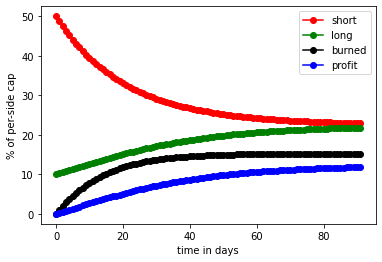

In [8]:
fa.show_imb(91)

# Profit profiles
The main variable of interest is the profit, encoded in the function `funding_earned`. In this section we examine the asymptotic profit for various balancing trades. We require this analysis becuase if the balancing OI is zero, then zero funding is earned, but if the balancing OI is equal to the entire imbalance, then zero funding is also earned. 

Given an arbitrary long amount (100 OVL below), we look at the total funding earned in the infinite time limit, for balancing trades between 0 and 100 OVL on the short side:

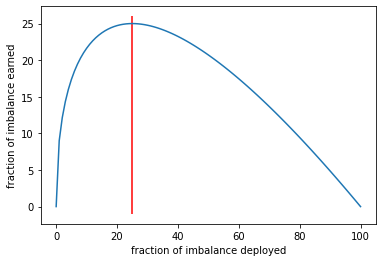

In [9]:
profile, rates = [], []
for long_ in [100]:#np.arange(0,100,1):
    for s in np.arange(0,long_+1, 1):
        fa = FundingAnalyzer(long=long_, short=s)
        rates.append(fa.funding_rate())
        profile.append(fa.funding_earned(np.inf))
plt.plot(profile)
plt.ylabel('fraction of imbalance earned')
plt.vlines(25, -1, 26, color='r') # maximum
_ = plt.xlabel('fraction of imbalance deployed')

### The ideal size to balance with to obtain the maximum OVL from funding is 25% of the imbalance. This is because once 25% has been burned and 25% given to the opposite side, both longs and shorts are perfectly balanced. Any other choice of initial balancing capital results in less OVL being passed to the basis trader. 

### The returns on capital look very different, however. Entering at 25% of the imbalance gives a 100% return, but entering with less OVL increases the return, with a discontinuity at 0 on the x axis:

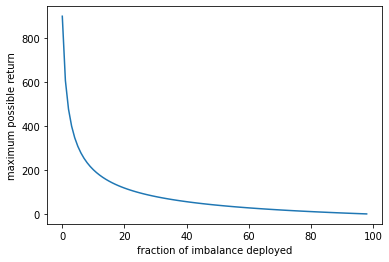

In [10]:
long = 100
profile = []
for s in range(1, long): 
    profile.append((FundingAnalyzer(long=long, short=s).funding_earned(np.inf))/(s*.01))
plt.plot(profile)
plt.ylabel('maximum possible return')
_ = plt.xlabel('fraction of imbalance deployed')

### These numbers represent the return after an infinite time collecting funding.  Below we plot the percentages of infinite-time profit, for various finite times.  We assume $k=.25$, an initial long at 100 OVL and a single 25 OVL balancing trade:



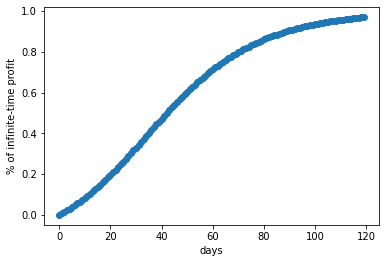

In [11]:
fa = FundingAnalyzer(long=1000, short=25, k=.02)
infinite_time = fa.funding_earned(np.inf) 
finite_times = np.array([fa.funding_earned(t) for t in np.arange(0,120,1)])
plt.plot(finite_times/infinite_time, marker='o')
plt.ylabel('% of infinite-time profit')
_ = plt.xlabel('days')

### After 30 days of sitting in the basis trade, assuming nothing else happens in the system and the basis trader entered with 25% of the imbalance, the returns are 60%. 

### Out of curiosity, let us look at how these numbers vary with different values of $k$:

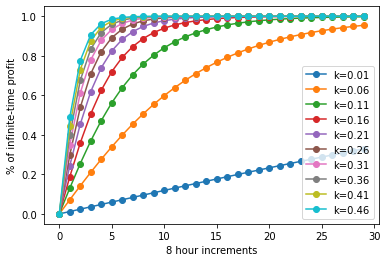

In [15]:
for k_tmp in np.arange(.01, .5, .05):
    fa_tmp = FundingAnalyzer(long=100, short=25, k=k_tmp)
    infinite_time = fa.funding_earned(np.inf) 
    finite_times = np.array([fa.funding_earned(t) for t in np.arange(0,30,1)])
    plt.plot(finite_times/infinite_time, marker='o', label=f'k={round(k_tmp,2)}')
    plt.ylabel('% of infinite-time profit')
    plt.xlabel('8 hour increments')
    plt.legend()

# Trade mechanics

Here we implement a class to examine the details of entering the basis trade, including cost of trading incurred



In [18]:
@dataclass
class TradeAnalyzer(FundingAnalyzer):
    # FundingAnalyzer class with extra capacities for examining basis trade

    # Overlay parameters
    O_gas: float = 2e4        # gas to enter Overlay trade
    O_tx_fee: float = 75e-4   # Overlay transaction fees in bps
    lambda_: float = .5       # Overlay slippage param

    # Uniswap parameters
    U_gas: float = 2e4        # gas to do Uniswap swap
    U_tx_fee: float = 30e-4   # Uniswap transaction fees in bps
    liquidity: float = 10e3  # total liquidity (both sides) in Uni ETH-OVL in units of ETH

    # EVM parameters
    EVM_gas: float = 50       # gas in Gwei

    # exchange rates
    ETHOVL: float = 1e3       # OVL per 1 ETH

    # Overlay and Uniswap parameters
    @property
    def capOI(self):          # Units are in ETH
        return  .5*self.liquidity*self.lambda_ # set at upper bound for worst-case scenario

    # Trading functions for Uniswap and Overlay
    def U_rel_price_up(self, trade_amount):  # Uniswap V3 relative price changes up
        return (1 + (trade_amount*2/self.liquidity))**2

    def U_rel_price_down(self, trade_amount):  # Uniswap V3 relative price changes down
        return 1 / self.U_rel_price_up(trade_amount)

    def U_slippage(self, trade_amount): #Uniswap V3 slippage
        return 1 - self.U_rel_price_down(trade_amount)

    def U_slippage(self, trade_amount): #Uniswap V3 slippage
        return 1 - self.U_rel_price_down(trade_amount)

    def slippage_sell_O(self, trade_amount): #Overlay slippage
        return 1 - np.exp(-self.lambda_ * trade_amount / self.capOI)

    def slippage_buy_O(self, trade_amount): #Overlay slippage
        return np.exp(self.lambda_ * trade_amount / self.capOI) - 1

    def get_size_after_U_fees(self, size):
        return (size * (1 - self.U_slippage(size)) * (1 - self.U_tx_fee)) - self.gas_to_ETH(self.U_gas)

    def size_after_sell_O(self, size):
        return (size * (1 - self.slippage_sell_O(size)) * (1 - self.O_tx_fee)) - self.gas_to_ETH(self.O_gas)

    def size_after_buy_O(self, size):
        return (size * (1 - self.slippage_buy_O(size)) * (1 - self.O_tx_fee)) - self.gas_to_ETH(self.O_gas)

    def get_size_after_roundtrip(self, trade_amount):
        #how much ETH we have left after  rountrip on Uni and Overlay, including all fees
        size1 = self.get_size_after_U_fees(trade_amount)
        size2 = self.size_after_sell_O(size1)
        size3 = self.size_after_buy_O(size2)
        return self.get_size_after_U_fees(size3)

    # EVM functions
    def gas_to_ETH(self, gas):
        return self.EVM_gas * gas * 10e-9

    # exchange functions
    def OVL_to_ETH(self, trade_amount):
        return trade_amount/self.ETHOVL

    def ETH_to_OVL(self, trade_amount):
        return trade_amount*self.ETHOVL

    # utility functions
    def get_breakeven_day(self, trade_amount, max_days=365, resolution=.25):
        new_size = self.get_size_after_roundtrip(trade_amount)
        for t in np.arange(0, max_days, resolution):
            if (new_size + self.funding_earned(t)) >= trade_amount:
                return t
        return f'Basis trade did not break even in {max_days} days'


In [30]:
for size in range(5, 50, 10):
    ta = TradeAnalyzer(size, 100)
    new_size = ta.get_size_after_roundtrip(size)
    print(ta.liquidity/2 , size, new_size, size*2/ta.liquidity, new_size/size -1)
            # assert np.isclose(new_size, ), 1 - 1/(1 + (size*2/self.ta.liquidity))**2)


5000.0 5 4.827281256958028 0.001 -0.034543748608394376
5000.0 15 14.390049975029342 0.003 -0.040663334998043865
5000.0 25 23.730492664438092 0.005 -0.050780293422476364
5000.0 35 32.85544624089379 0.007 -0.061272964545891706
5000.0 45 41.77148547640568 0.009 -0.07174476719098488


In [34]:
for size in range(5, 50, 10):
    ta = TradeAnalyzer(size, 100)
    #print(ta.k)
    print(ta.get_breakeven_day(size))


1.0
1.5
2.25
3.25
5.0
